# Core Competencies of Ericksonian Therapy

This notebook describes the preparation of the *Core Competencies* multilingual [dataset](https://huggingface.co/datasets/LoneWolfgang/ericksonian-core-competencies-multilingual).

The *Core Competencies* is a training manual that explores the history and methodology of Ericksonian therapy. The original [English](../data/documents/core_competencies/CCET-en.pdf) version has been translated into four languages:
 - [French](../data/documents/core_competencies/CCET-fr.pdf)
 - [Italian](../data/documents/core_competencies/CCET-it.pdf)
 - [Portuguese](../data/documents/core_competencies/CCET-pt.pdf)
 - [Spanish](../data/documents/core_competencies/CCET-es.pdf)

The manual has also been translated into [Indonesian](../data/documents/core_competencies/CCET-id.pdf). However, unlike the other translations, the Indonesian manual reorganizes the material and introduces original content. It remains to be seen whether portions of this version align more closely at the sentence level. Future updates may include Indonesian data.

## Setup

To follow along, you will need to install the purpose built Python package, `docutrance`. This will install depencies and some custom objects.

```
pip install docutrance
```

## Outline

This notebook is divided into three sections:

- **Section Alignment**  
  This section explains how content and headers were manually extracted from the raw material and organized into a structured corpus JSON file.

- **Sentence Alignment**  
  This section describes how a multilingual sentence embedder was used to automatically align sentences across languages, proceeding section by section.

- **Evaluation**  
  This section outlines the contents of the dataset and highlights current shortcomings that may need to be addressed in downstream tasks.

## Section Alignment

The *Core Competencies* manual was translated by teams of native speakers with expertise in Ericksonian therapy. Efforts were made to closely follow the structure of the original English version. However, natural differences in discourse structure across languages entail some divergence in sentence and paragraph organization. As a result, even high-quality translations require context-aware methods for accurate sentence alignment.

To align sentences, we will use a multilingual SBERT model to encode and compare sentences via cosine similarity. Notably, the same model used for alignment will eventually be finetuned during training. This approach carries some risk: if the initial model produces poor alignments, its biases will persist through training. To mitigate this, we will leverage the document structure. Between translations, chapters and sections are perfectly aligned. Thus, sentence alignment will proceed section by section. This approach not only improves accuracy by narrowing the alignment context but also reduces memory usage.

The contents of the *Core Competencies* were manually extracted and structured into [JSON](../data/corpora/core_competencies.json):
```
{
    "section_id": {
        "language": {
            "header": "...",
            "content": "..."
        },
        ...
    },
}
```

 - **section_id**: A string identifier representing the chapter and section (e.g., "1-1", "2-3)
 - **language**: An ISO 639-1 language code—either 'en', 'fr', 'it', 'pt', or 'es'.
 - **header**: The section header extracted from the source document.
 - **contenut**: The full text content of the corresponding section.

In [2]:
from pathlib import Path
import json
import random

path = '../data/corpora/core_competencies.json'
load_json = lambda path: json.loads(Path(path).read_text())

corpus = load_json(path)

sections = list(corpus.keys())
langs = list(corpus[sections[0]].keys())
section, lang = random.choice(sections), random.choice(langs)
entry = corpus[section][lang]

print("Sections:", sections[:4], '. . .', sections[-4:])
print("Languages:", langs)
print()
print(f"Entry for Section {section}, {lang}:\n")
print("\tHeader:", entry["header"])
print("\tContent:", entry["content"][:64], '. . .')



Sections: ['0-1', '0-2', '0-3', '0-4'] . . . ['4-3', '5-1', '5-2', '5-3']
Languages: ['en', 'es', 'fr', 'it', 'pt']

Entry for Section 0-3, it:

	Header: COME È STATO CREATO QUESTO MANUALE
	Content: Diversamente dalle altre scuole tradizionali di psicoterapia, la . . .


## Sentence Alignment

To perform sentence alignment, we first need to split paragraphs into individual sentences. However, sentence tokenization is not language-agnostic. Different languages require different rules and models to tokenize correctly. 

To handle this, we use a set of language-optimized tokenizers trained by [spaCy](https://spacy.io/universe/project/spacy-udpipe) as part of the Universal Dependencies (UD) project. These UD-based tokenizers are lightweight and performant when the language is explicitly defined.

To simplify the implementation, we use the class **`docutrance.preprocess.UDSentenceTokenizer`**. Given a list of languages, this class automatically downloads the necessary language models and stores the tokenizers in memory for reuse.

In [13]:
from docutrance.preprocess import UDSentenceTokenizer

paragraphs = {
    "en": "Hello World. How are you?",
    "es": "Hola mundo. ¿Cómo estás?",
    "fr": "Bonjour tout le monde. Comment allez-vous?",
    "it": "Ciao mondo. Come stai?",
    "pt": "Olá, mundo. Como você está?"
}

languages = list(paragraphs.keys())
tokenizer = UDSentenceTokenizer(languages)

sentences = {k: tokenizer.tokenize(k, v) for k,v in paragraphs.items()}

print()
for lang, sents in sentences.items():
    print(f'{lang}:', sents)

Initializing UD Tokenizer for ['en', 'es', 'fr', 'it', 'pt']. . .
Already downloaded a model for the 'en' language
Already downloaded a model for the 'es' language
Already downloaded a model for the 'fr' language
Already downloaded a model for the 'it' language
Already downloaded a model for the 'pt' language

en: ['Hello World.', 'How are you?']
es: ['Hola mundo.', '¿Cómo estás?']
fr: ['Bonjour tout le monde.', 'Comment allez-vous?']
it: ['Ciao mondo.', 'Come stai?']
pt: ['Olá, mundo.', 'Como você está?']


To align sentences, we use the best-performing multilingual model from [SBERT](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2).

The function **`docutrance.preprocess.align_sentences`** takes three arguments: `source_sentences`, `target_sentences`, and `model`.

1. The model encodes both the source and target sentences into dense vector representations.
2. A cosine similarity matrix is computed between each pair of source and target sentences.
3. For each source sentence, the function selects the best-matching target sentence along with its similarity score.

In [14]:
from docutrance.preprocess import align_sentences
from sentence_transformers import SentenceTransformer
import pandas as pd
import random


languages = list(sentences.keys())
source, target = random.sample(languages, 2)
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

print(f"Matching {source} to {target}")
pd.DataFrame.from_dict(align_sentences(
    sentences[source],
    sentences[target],
    model
))

Matching en to pt


,source,target,score
0,Hello World.,"Olá, mundo.",0.976401
1,How are you?,Como você está?,0.992821


The function **`docutrance.preprocess.align_sentences_process`** is hard-coded for  corpus structure defined in this notebook. It processes the data section by section and language by language, producing a separate dataframe for each section–language pair. Once all subsets are processed, the intermediate dataframes are concatenated into a single final output.

The function takes two arguments:

- **`io_paths`**: A dictionary containing paths for the input corpus and the final output file.
- **`model`**: A multilingual sentence embedding model used to align sentences between languages.


In [40]:
from docutrance.preprocess import align_core_competencies
from sentence_transformers import SentenceTransformer
from pathlib import Path

data = Path('../data')

io_paths = {
    "corpus": data / "corpora" / "core_competencies.json",
    "output": data / "tables" / "core_competencies.parquet"
}

model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

align_core_competencies(
    io_paths,
    model
)

Initializing UD Tokenizer for ['en', 'es', 'fr', 'it', 'pt']. . .
Already downloaded a model for the 'en' language
Already downloaded a model for the 'es' language
Already downloaded a model for the 'fr' language
Already downloaded a model for the 'it' language
Already downloaded a model for the 'pt' language


Aligning sections:   0%|          | 0/107 [00:00<?, ?it/s]

Combined intermediate outputs. Saved to ..\data\tables\core_competencies.parquet


## Evaluation

Now the the sentences have been aligned, the final steps are to evaluate the data and identify shortcomings that need to be adressed before training.

### Santity Check

Start by loading the data and exploring its contents.

In [9]:
#Loads the processed dataframe and prints the first five rows.
import pandas as pd


file = '../data/tables/core_competencies.parquet'
df = pd.read_parquet(file)
df.head(5)

,section_id,target_language,english_header,english_sentence,non_english_header,non_english_sentence,similarity_score
0,0-1,es,Introduction to the Core Competencies Manual o...,The Ericksonian approach to therapy represents...,Introduzione al Manuale per le Competenze Chia...,"El abordaje terapéutico Ericksoniano, represen...",0.955194
1,0-1,es,Introduction to the Core Competencies Manual o...,People who identify themselves as being an Eri...,Introduzione al Manuale per le Competenze Chia...,Personas que se identifican a sí mismos siendo...,0.900950
2,0-1,es,Introduction to the Core Competencies Manual o...,"The Milton H. Erickson Foundation, Inc. was in...",Introduzione al Manuale per le Competenze Chia...,La fundación M. Erickson fue creada el 29 de O...,0.795812
3,0-1,es,Introduction to the Core Competencies Manual o...,"To this end, the Foundation provides ongoing e...",Introduzione al Manuale per le Competenze Chia...,"Desde Milton Erickson hasta la fecha, la Funda...",0.854311
4,0-1,es,Introduction to the Core Competencies Manual o...,In addition to the work of the Erickson Founda...,Introduzione al Manuale per le Competenze Chia...,Se agrega al trabajo de la Fundación de Ericks...,0.970191


In [12]:
#Selects a random example from each language subset and prints the contents.
import random

for lang, subset in df.groupby('target_language'):
    idx = random.choice(df.index)
    print(f"en-{lang}")
    for column in ["english_header", "non_english_header", "english_sentence", "non_english_sentence", "similarity_score"]:
        value = str(df.loc[idx, column])
        value = value[:64] + '. . .' if len(value) > 64 else value
        print(f"{column}: \t{value}")
    print()
    

en-es
english_header: 	CORE COMPETENCIES SCALES (CCS-6)
non_english_header: 	ÉCHELLES DE COMPÉTENCES FONDAMENTALES (ECF-6)
english_sentence: 	Relatively high covariance between subjects ( = .76) suggests t. . .
non_english_sentence: 	La covariance relativement élevée entre les sujets (= 0,76) sugg. . .
similarity_score: 	0.9329991340637207

en-fr
english_header: 	DESTABILIZATION: A readiness to disrupt stable psychological pat. . .
non_english_header: 	DESESTABILIZACIÓN: Disposición a interrumpir patrones psicológic. . .
english_sentence: 	For additional effect, the therapist might add, “You wanted to b. . .
non_english_sentence: 	Para un efecto adicional, el terapeuta puede agregar “Ud. quiere. . .
similarity_score: 	0.8467073440551758

en-it
english_header: 	Glossary of Ericksonian Terminology
non_english_header: 	GLOSSAIRE DE LA TERMINOLOGIE ÉRICKSONIENNE
english_sentence: 	Tracking –
non_english_sentence: 	T Tracking11 — Forme de retour d'information verbale qui décrit . . .
simil

### Cleansing

A superficial examination of the data suggest that it is in good shape. The next step is cleansing, which involves a deeper analysis of data quality and filtering out problematic rows.

Cleansing focuses on five features: `duplicate rows`, `mismatched sentence lengths`, `underlength sentences`, `low similarity scores`, and `overlength sentences`.

#### Duplicate Rows

The sentence alignment algorithm chooses the best-match non-English sentence for each English sentence. Therefore, the same non-English sentence is matched to many different English sentences.

We will use the function, `docutrance.preprocess.preprocess_core_competencies`, which is designed specefically for this dataset. Given the raw dataset, it will deduplicate both the English and non-English sentence columns, keeping only the best match pairing.

Raw Dataset: 7379 rows
Deduplicated: 5848 rows

|       |   similarity_score |
|-------|--------------------|
| count |        5848        |
| mean  |           0.896683 |
| std   |           0.081781 |
| min   |           0.298372 |
| 25%   |           0.859458 |
| 50%   |           0.920699 |
| 75%   |           0.955866 |
| max   |           1        |


array([[<Axes: title={'center': 'similarity_score'}>]], dtype=object)

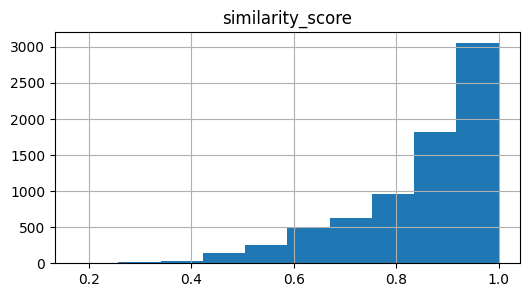

In [15]:
from tabulate import tabulate
from docutrance.preprocess import preprocess_core_competencies

file = '../data/tables/core_competencies.parquet'
df = pd.read_parquet(file)
results = preprocess_core_competencies(df)

print("Raw Dataset:", len(df), "rows")
print("Deduplicated:", len(results), "rows")
print()

print(tabulate(results.describe(), headers='keys', tablefmt='github'))
df.hist('similarity_score', bins=10, figsize=(6, 3))

Deduplication reduces the dataset size by about 20%. The remaining examples are strongly matched, with the mean similarity score at nearly 0.9 and only an outlying minority below 0.4.


#### Mismatched Sentence Lengths

Differences in formatting and tokenizer behavior between the original document and its translations led to inconsistent sentence segmentation. Beyond a certain threshold, these inconsistently segmented sentences no longer make viable training pairs.

To quantify this, the `relative length difference` is calculated by dividing the absolute difference in token sequence lengths by their average. This normalization magnifies length mismatches in shorter sequences and diminishes them in longer ones.

The working hypothesis is that a larger relative length difference indicates poor sentence alignment. Accordingly, the quality of the training data is assessed by progressively removing sentence pairs with increasingly large relative length differences.

The function `docutrance.preprocess.analyze_len_difference_similarity` visualizes the change:

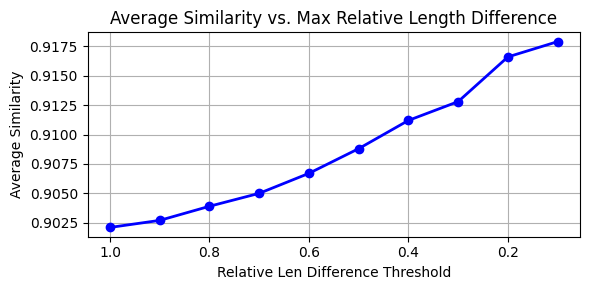

| Max Relative Len Diff   |   Avg Similarity |   Data Retained (%) |
|-------------------------|------------------|---------------------|
| -                       |           0.8967 |              100    |
| 1.0                     |           0.9021 |               96.46 |
| 0.9                     |           0.9027 |               95.98 |
| 0.8                     |           0.9039 |               95.02 |
| 0.7                     |           0.905  |               94.2  |
| 0.6                     |           0.9067 |               92.36 |
| 0.5                     |           0.9088 |               89.79 |
| 0.4                     |           0.9112 |               85.38 |
| 0.3                     |           0.9128 |               78.76 |
| 0.2                     |           0.9166 |               63.13 |
| 0.1                     |           0.9179 |               36.17 |


In [17]:
from docutrance.preprocess import analyze_len_difference_vs_similarity
import pandas as pd

    
df = pd.read_parquet('../data/tables/core_competencies.parquet')
analyze_len_difference_vs_similarity(df)


When enforcing a maximum length difference, **average similarity** climbs gradually.

However, this comes at a cost—**data retention drops sharply** once the threshold falls below **0.5**.

#### Underlength Sentences

During tokenization, some formatting artifacts, such as list markers, page dividers, and common headings, were extracted as standalone sentences. These segments are often paired incorrectly, despite recieving a relatively high similarity score. Even when correctly aligned, these minimal fragments are usually trivial for the baseline model to interpret, making them uninformative for training.

The following code block displays examples with 1 to 5 tokens, illustrating how sequence quality improves once a minimum length threshold is enforced:

In [9]:
from docutrance.preprocess import preprocess_core_competencies
import pandas as pd

# Load the DataFrame with token lists and the relative length differences.
file = '../data/tables/core_competencies.parquet'
df = pd.read_parquet('../data/tables/core_competencies.parquet')
filters = [
    lambda df: df.relative_len_diff <= 0.5
]


results = preprocess_core_competencies(
    df,
    filters = filters,
    remove_intermediate_columns= False
)

print_columns = [
    'english_sentence', 
    'non_english_sentence',
    'similarity_score'
    ]
for n in [1, 5]:
    subset = results[results.english_words.apply(lambda x: len(x) == n)][print_columns].sample(5)
    print(f"Examples with {n} tokens:")
    print()
    print(tabulate(
        subset, 
        headers='keys',
        showindex=False, 
        tablefmt='github'
        ))
    print()

Examples with 1 tokens:

| english_sentence   | non_english_sentence   |   similarity_score |
|--------------------|------------------------|--------------------|
| II.                | II.                    |           1        |
| Naturalistic:      | Naturalistico:         |           0.935369 |
| Reliability        | Confiabilidade         |           0.856927 |
| II.                | 2.                     |           0.847311 |
| 1                  | 1                      |           1        |

Examples with 5 tokens:

| english_sentence                                  | non_english_sentence                                |   similarity_score |
|---------------------------------------------------|-----------------------------------------------------|--------------------|
| The qualitative information is optional.          | Les informations qualitatives sont facultatives. 3. |           0.789834 |
| The qualitative information is optional.          | La información cualitativ

#### Misaligned Sentences

Sentence pairs with similarity scores below a certain threshold are likely to be misaligned and should be withheld from training. However, this must be done with care. While correctly aligned pairs with high similarity scores help anchor the model to the ground truth, they offer limited learning value. In contrast, correctly aligned pairs with low similarity scores represent the best opportunity for the model to learn novel or difficult relationships.

For this iteration, a minimum similarity threshold of 0.7 was heuristically chosen. In a future update, this dataset will undergo human review to validate alignments and refine threshold selection.

In [18]:
from docutrance.preprocess import preprocess_core_competencies
import pandas as pd

# Load the DataFrame with token lists and the relative length differences.
file = '../data/tables/core_competencies.parquet'
df = pd.read_parquet(file)
filters = [
    lambda df: df.relative_len_diff <= 0.5,
    lambda df: df.english_sentence.apply(len) > 4,
    lambda df: df.non_english_sentence.apply(len) > 4,
]


results = preprocess_core_competencies(
    df,
    filters = filters,
    remove_intermediate_columns= False
)


for n in [0.5, 0.6, 0.7]:
   for _, row in results[results.similarity_score.between(n, n+0.1)].sample(1).iterrows():
      
      print("Score:", round(row.similarity_score, 4))
      print()
      print("English:", row['english_sentence'])
      print("non-English:", row['non_english_sentence'])
      print()
   print()


Score: 0.5007

English: PsyD. Entitled Current Research and Thinking in Brief
non-English: Se le idee di il Dott.


Score: 0.6939

English: Most of the therapy discussion was confined to the office.
non-English: La mayoría de las discusiones terapéuticas quedan reducidas al consultorio.


Score: 0.7421

English: It is not an easy place to work, and needs always exceed resources, but finding ways to make thing happen, and happen well takes a special kind of person.”
non-English: No es un lugar fácil de trabajar, y las necesidades siempre superan los recursos, pero encontrar maneras de hacer que la cosa suceda, y suceda bien necesita un tipo especial de persona” Institutos: Cuando se formóla Fundacion Erickson, muchos institutos pequeños locales solicitaron permiso del Dr.




#### Overlength Sentences

The final consideration is the length of tokenized sequences relative to the model’s input constraints. The target model has a maximum context window of 128 tokens. Fortunately, analysis shows that most sequences fall well below this limit. Outlier sequences that exceed the maximum length will be excluded from the training set.

In [19]:
from docutrance.preprocess import preprocess_core_competencies
import pandas as pd
from sentence_transformers import SentenceTransformer

# Load the DataFrame with token lists and the relative length differences.
file = '../data/tables/core_competencies.parquet'
df = pd.read_parquet('../data/tables/core_competencies.parquet')
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
filters = [
    lambda df: df.relative_len_diff <= 0.5,
    lambda df: df.english_sentence.apply(len) > 4,
    lambda df: df.non_english_sentence.apply(len) > 4,
    lambda df: df.similarity_score >= 0.7
]

results= preprocess_core_competencies(
    results,
    model=model,
    filters=filters,
    remove_intermediate_columns=False
)

get_token_len = lambda column: results[column].apply(lambda x: len(x))
results['english_sequence_length'] = get_token_len('english_tokens')
results['non_english_sequence_length'] = get_token_len('non_english_tokens')

print()
print(tabulate(
    results[['english_sequence_length', 'non_english_sequence_length']].describe(),
    headers='keys',
    tablefmt='github'))

Token indices sequence length is longer than the specified maximum sequence length for this model (203 > 128). Running this sequence through the model will result in indexing errors



|       |   english_sequence_length |   non_english_sequence_length |
|-------|---------------------------|-------------------------------|
| count |                 5200      |                     5200      |
| mean  |                   31.3144 |                       35.6779 |
| std   |                   15.1259 |                       17.6619 |
| min   |                    2      |                        2      |
| 25%   |                   21      |                       24      |
| 50%   |                   29      |                       33      |
| 75%   |                   38      |                       44      |
| max   |                  203      |                      260      |


## Final Considerations

The final analysis shows how much data was lost to cleansing and checks the balance by language.

In [20]:
from docutrance.preprocess import preprocess_core_competencies
import pandas as pd
from sentence_transformers import SentenceTransformer

file = '../data/tables/core_competencies.parquet'
df = pd.read_parquet(file)
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
filters = [
    lambda df: df.relative_len_diff <= 0.5,
    lambda df: df.english_sentence.apply(len) > 4,
    lambda df: df.non_english_sentence.apply(len) > 4,
    lambda df: df.similarity_score >= 0.7,
    lambda df: df.english_tokens.apply(len) <= 128,
    lambda df: df.non_english_tokens.apply(len) <= 128
]

results = preprocess_core_competencies(
    df,
    model=model,
    filters=filters
)

print()

print("Raw Dataset:", f"{len(df)} rows")
print("Filtered Dataset:", f"{len(results)} rows")
print(f"Data retained: {len(results) / len(df) * 100:.2f}%")
print()
print(tabulate(
    results.groupby('target_language').agg({'english_sentence': 'count'}), 
    headers = ['Language', 'Examples'],
    tablefmt='github'))

Token indices sequence length is longer than the specified maximum sequence length for this model (203 > 128). Running this sequence through the model will result in indexing errors



Raw Dataset: 7379 rows
Filtered Dataset: 5192 rows
Data retained: 70.36%

| Language   |   Examples |
|------------|------------|
| es         |       1236 |
| fr         |       1314 |
| it         |       1409 |
| pt         |       1233 |


Although 30% of the dataset was removed, the remaining data remains well balanced across languages. This is a positive sign, suggesting that the problematic features were evenly distributed rather than concentrated in one language.